# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [20]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

In [4]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-031195453414


## Dataset
dog breed classification dataset. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets. you can find the data set [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

In [5]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-10-31 16:08:16--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  42.6MB/s    in 54s     

2022-10-31 16:09:13 (20.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [5]:
# uploading the data to s3
prefix ="dog-bread-Images-Dataset"
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

In [6]:
print(inputs)

s3://sagemaker-us-east-1-031195453414/dog-bread-Images-Dataset


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
from sagemaker.tuner import (CategoricalParameter,
                             ContinuousParameter,
                             HyperparameterTuner)

In [6]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [9]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.xlarge", 
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": "s3://sagemaker-us-east-1-031195453414/dog-bread-Images-Dataset" }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-11-01 00:40:26 Starting - Found matching resource for reuse
2022-11-01 00:40:26 Downloading - Downloading input data
2022-11-01 00:40:26 Training - Training image download completed. Training in progress.
2022-11-01 00:40:26 Uploading - Uploading generated training model
2022-11-01 00:40:26 Completed - Resource reused by training job: pytorch-training-221031-2240-003-c8e60bc3


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '7.989936070693411e-09',
 'lr': '0.0011846225016563922',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2022-10-31-22-40-48-285"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-031195453414/dog-breed-classification-hpo-2022-10-31-22-40-48-285/source/sourcedir.tar.gz"',
 'weight_decay': '0.003915513575774384'}

In [12]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '7.989936070693411e-09', 'lr': '0.0011846225016563922', 'weight_decay': '0.003915513575774384'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# TODO: Set up debugging and profiling rules and hooks
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [15]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    role=role,
    framework_version="1.6", 
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : "s3://sagemaker-us-east-1-031195453414/dog-bread-Images-Dataset" },wait=True)# TODO: Create and fit an estimator


2022-11-01 03:40:35 Starting - Starting the training job...
2022-11-01 03:41:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-11-01 03:42:31 Downloading - Downloading input data............
2022-11-01 03:44:31 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-01 03:44:21,001 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-01 03:44:21,004 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-01 03:44:21,016 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-01 03:44:21,023 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-01 03:44:21,

In [16]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [17]:
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-11-01-03-40-34-459
Client: <botocore.client.SageMaker object at 0x7fbb0c91c410>
Description: {'TrainingJobName': 'pytorch-training-2022-11-01-03-40-34-459', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:031195453414:training-job/pytorch-training-2022-11-01-03-40-34-459', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"7.989936070693411e-09"', 'lr': '"0.0011846225016563922"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-11-01-03-40-34-459"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/source/sourcedir.tar.gz"', 'weight_decay': '"0.003915513575774384"'}, 'AlgorithmSpecif

In [21]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-11-01 05:50:29.443 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:376 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-01 05:50:29.454 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:376 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/debug-output


In [22]:
trial.tensor_names() #all the tensor names

[2022-11-01 05:50:33.306 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:376 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-11-01 05:50:34.343 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:376 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [23]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

11
14


In [24]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()


loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


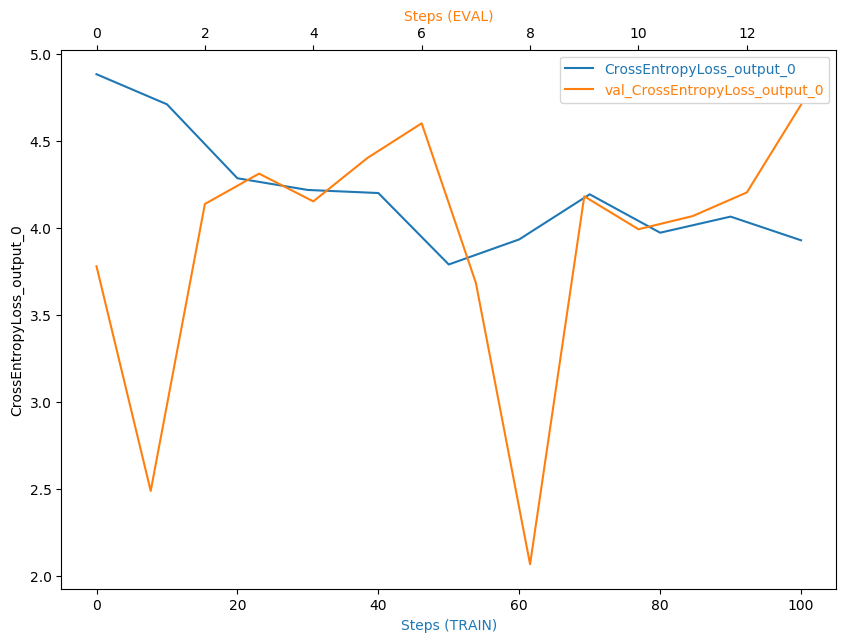

In [25]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [26]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/rule-output


In [27]:
! aws s3 ls {rule_output_path} --recursive

2022-11-01 04:41:14     375416 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-11-01 04:41:14     223333 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-11-01 04:41:09        192 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-11-01 04:41:09        200 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-01 04:41:09       1889 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-11-01 04:41:09        127 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-11-01 04:41:09        199 pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-re

In [28]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-03-40-34-459

In [29]:
import os

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]][0]

In [30]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [31]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/final_project/profiler_report.zip'

## Model Deploying

In [32]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

------!

In [33]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

# Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
# model_data_artifacts = "s3://sagemaker-us-east-1-881607171913/pytorch-training-220607-1708-003-de60ee22/output/model.tar.gz"
model_data_artifacts = "s3://sagemaker-us-east-1-031195453414/pytorch-training-2022-11-01-05-51-52-204/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                             role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor)

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") #Using ml.t2.medium to save costs

------------!

Test image no: 1
Below is the image that we will be testing:


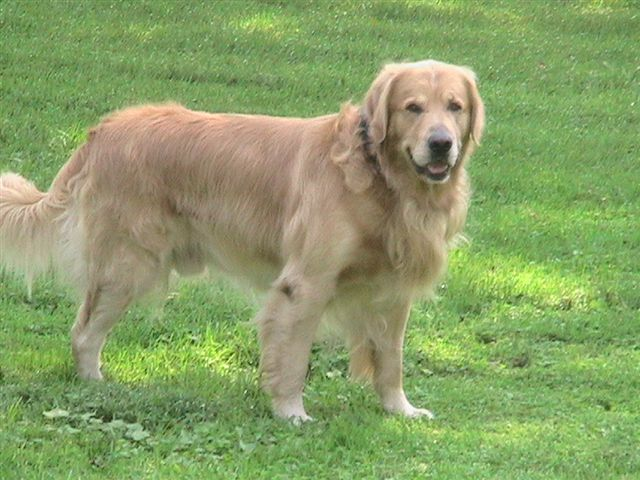

Expected dog breed category no : 76
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.538959264755249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [61]
----------------------------------------------------------------------
Test image no: 2
Below is the image that we will be testing:


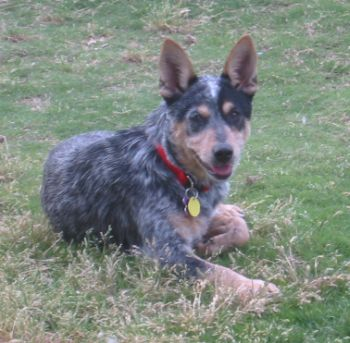

Expected dog breed category no : 11
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4530401229858398, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26563510298728943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2498428076505661, 0.0, 0.0, 0.0, 0.17757347226142883, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5895950794219971, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [28]
----------------------------------------------------------------------
Test image no: 3
Below is the image that we will be testing:


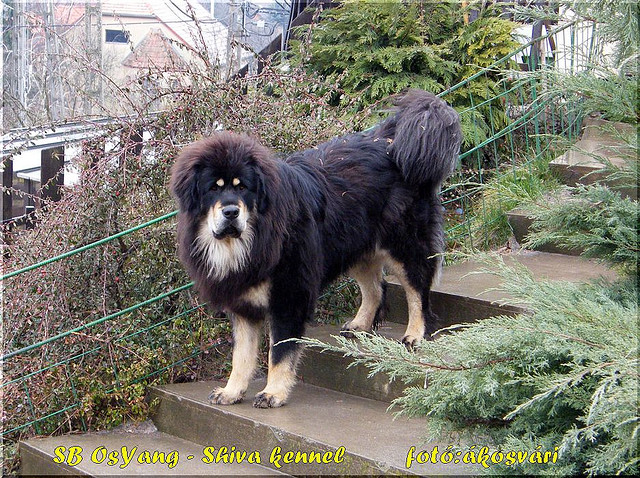

Expected dog breed category no : 21
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5386970043182373, 0.0, 0.0, 0.0, 0.0, 1.268587589263916, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48834428191185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [23]
----------------------------------------------------------------------


In [40]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./dogImages/test/"
test_images = ["076.Golden_retriever/Golden_retriever_05258.jpg", '011.Australian_cattle_dog/Australian_cattle_dog_00788.jpg', "129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [76, 11, 21]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")
        print("----------------------------------------------------------------------")

In [41]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2022-11-01-05-55-29-085


Test image no: 1
Below is the image that we will be testing:


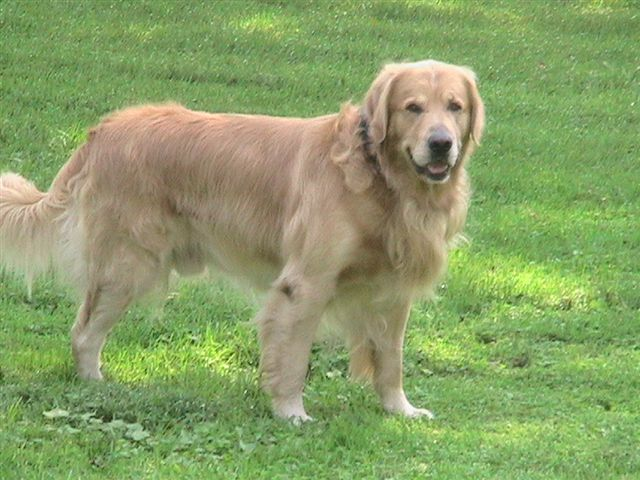

Expected dog breed category no : 76
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.53895926 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.      

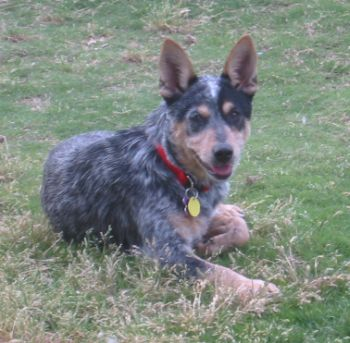

Expected dog breed category no : 11
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.45304012 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.2656351
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0

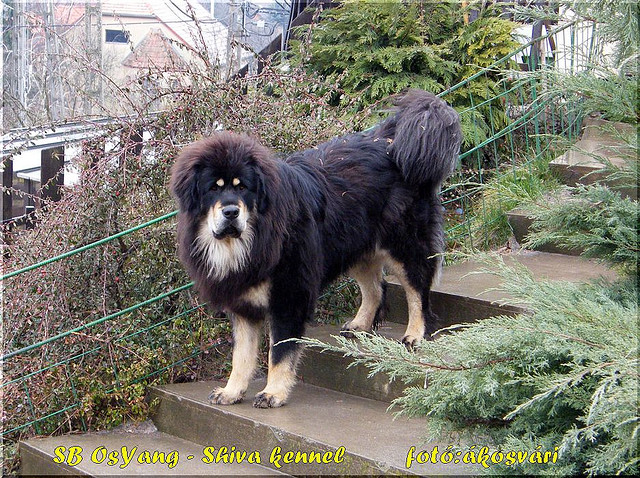

Expected dog breed category no : 21
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.538697
  0.         0.         0.         0.         1.26858759 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.48834428 0.         0.         0.

In [43]:
# Solution 2: Using boto3
# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL
# setting the  environment variables

ENDPOINT_NAME = endpoint_name
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./dogImages/test/"
test_images = ["076.Golden_retriever/Golden_retriever_05258.jpg", '011.Australian_cattle_dog/Australian_cattle_dog_00788.jpg', "129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [76, 11, 21]

for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")


In [44]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()